In [200]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.time import Time

In [201]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

## Observavility

In [202]:
import astroplan
from astroplan import FixedTarget, Observer
from astroplan.plots import plot_airmass, plot_altitude

# https://arxiv.org/pdf/2012.12824.pdf
C3 = FixedTarget(name='SN-C3', coord=SkyCoord(52.6484, -28.1000, unit='deg'))
X3 = FixedTarget(name='SN-X3', coord=SkyCoord(36.4500, -4.6000, unit='deg'))
E2 = FixedTarget(name='SN-E2', coord=SkyCoord(9.5000,  -43.9980, unit='deg')) ## Too low

COSMOS = FixedTarget(name='COSMOS', coord=SkyCoord(150.11916667, 2.20583333, unit='deg'))

targets = [C3, X3, E2, COSMOS]

In [409]:
for t in targets:
    print(t.name)
    print(t.coord.ra.hourangle, t.coord.dec.deg)
    # 
    print(t.coord.ra.to_string(unit=u.hour),
          t.coord.dec.to_string(u.degree, alwayssign=True))
    print('.....')

SN-C3
3.509893333333334 -28.1
3h30m35.616s -28d06m00s
.....
SN-X3
2.4300000000000006 -4.6
2h25m48s -4d36m00s
.....
SN-E2
0.6333333333333334 -43.998
0h38m00s -43d59m52.8s
.....
COSMOS
10.007944444666668 2.20583333
10h00m28.6000008s +2d12m20.999988s
.....


In [203]:
observer = Observer.at_site('palomar')

In [403]:
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint)
constraints = [AltitudeConstraint(20*u.deg), astroplan.MoonSeparationConstraint(0.5*u.deg),
               AirmassConstraint(5), AtNightConstraint.twilight_civil()]

astroplan.months_observable(constraints, observer, targets)

[{1, 2, 3, 7, 8, 9, 10, 11, 12},
 {1, 2, 3, 6, 7, 8, 9, 10, 11, 12},
 set(),
 {1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12}]

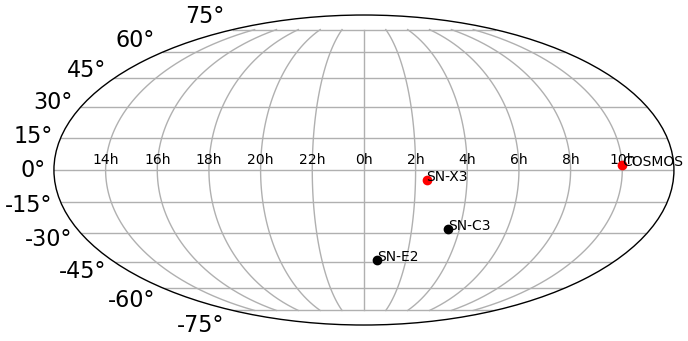

In [369]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
for t in targets:
    if t.name == 'COSMOS' or t.name == 'SN-X3':
        color='r'
    else:
        color='k'
    ax.text(t.coord.ra.radian, t.coord.dec.radian, t.name, zorder=11)
    ax.scatter(t.coord.ra.radian, t.coord.dec.radian, color=color, zorder=10)

ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'], fontsize=10)
ax.grid(True)

fig.savefig('sky.eps', format='eps')

In [205]:
AltitudeConstraint(20*u.deg)

/Users/colinburke/miniconda3/lib/python3.11/site-packages/matplotlib/ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


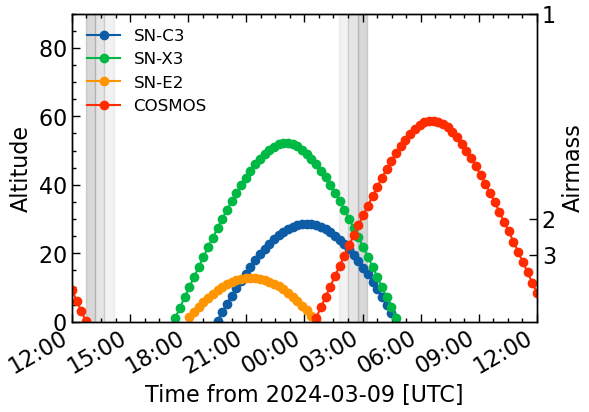

In [340]:
dt = 1*u.day
observe_time = Time("2024-03-10")

fig, ax = plt.subplots(1,1, figsize=(6, 4))

for t in [targets]:
    plot_altitude(t, observer, observe_time, brightness_shading=True, airmass_yaxis=True, ax=ax)

ax.legend(shadow=True, loc=2, fontsize=12)

### Follow-up to get spec-z to enable SED fitting:

In [11]:
# Read HSC-SSP AGNs
data_agn = ascii.read('hsc_agn_updated.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')

In [272]:
mask_ph = data_agn_cosmos['z']==data_agn_cosmos['z_phot']
#mask_br = r < 22
mask_br =  data_agn_cosmos['i-mag'] < 22

data_agn_cosmos[mask_ph & mask_br]

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,ID-COSMOS2015,z,z_phot,z0,z1,z2,z3,z4,z5,r_z,r_z0,r_z1,r_z4
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
23,150.53187,2.18892,21.58,1,1,1,1,1,6,585366,0.83,0.83,0.83,0.83,-1.0,0.83,0.827,-1.0,0,3,6,1
217,150.05858,2.73034,21.69,1,1,1,1,1,6,942113,2.04,2.04,-1.0,-1.0,-1.0,2.04,1.141,-1.0,3,-1,-1,3
455,150.14082,2.73189,21.19,0,1,1,1,1,6,942848,1.28,1.28,-1.0,-1.0,-1.0,1.28,0.4,-1.0,3,-1,-1,4
459,149.63865,2.289,20.25,0,1,1,1,1,6,652276,1.95,1.95,-1.0,-1.0,-1.0,1.95,0.23,-1.0,3,-1,-1,4


In [372]:
#data_agn_des[~mask_ph]

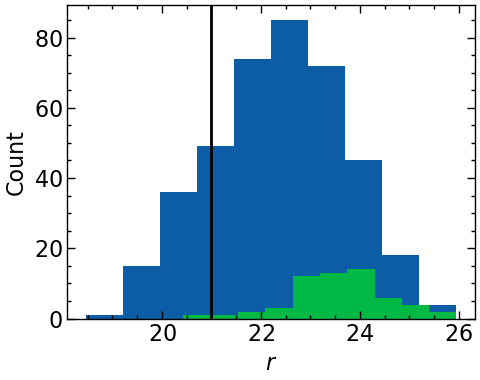

In [223]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.hist(r)
ax.hist(r[mask_ph], label='no spec-z')

ax.axvline(21, c='k')

ax.set_xlabel(r'$r$')
ax.set_ylabel('Count')

fig.tight_layout()

In [224]:
# TODO: Also read Chandra COSMOS legacy and re-do Mar's analysis

In [225]:
# Burke sources

data_agn_des = ascii.read('../dwarf_agn_cosmos/des/des_agn_updated.txt')
data_agn_des

Name,RA,dec,$g$,SNR,$\sigma_{\rm{LB}}$,$\log\ \frac{M_{\ast}}{M_{\odot}}$,$\Delta\chi_\nu^2$,"$\log\ \frac{\tau_{\rm{\textsc{DRW},rest}}}{\rm{days}}$",$z_{\rm{ph}}$,$z_{\rm{sp}}$,$z_{\rm{sp}}$ source,$W1{-}W2$,$\log \frac{F_{2-7 {\rm{\ keV}}}}{{\rm{erg\ s}}^{-1} {\rm{\ cm}}^{-2}}$,Field
str20,float64,float64,float64,float64,float64,str14,float64,str16,str22,float64,str4,float64,float64,str5
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,$1.02^{+0.03}_{-0.04}$,nan,None,0.4,nan,SN-C3
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,$0.24^{+0.04}_{-0.02}$,nan,None,18.6,nan,SN-C3
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,$1.09^{+0.02}_{-0.02}$,nan,None,0.9,nan,SN-C3
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,$1.30^{+0.10}_{-0.15}$,nan,None,1.1,nan,SN-C3
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,$0.60^{+0.25}_{-0.05}$,nan,None,nan,nan,SN-C3
J032850.22-271208.00,52.2093,-27.2022,19.2,26.1,20.3,$10.2 \pm 0.6$,0.0,$2.7 \pm 0.6$,$0.90^{+0.40}_{-0.30}$,0.803,SIMB,1.1,nan,SN-C3
J032913.11-271213.79,52.3046,-27.2038,22.9,21.6,17.2,$10.4 \pm 0.5$,0.3,$2.2 \pm 0.7$,$1.25^{+0.15}_{-0.10}$,nan,None,1.0,nan,SN-C3
J032847.11-271553.99,52.1963,-27.265,21.1,23.6,19.0,$7.3 \pm 0.1$,3.2,$3.6 \pm 0.4$,$0.08^{+0.03}_{-0.04}$,2.9784,2dF,18.1,nan,SN-C3
J033039.78-271740.97,52.6658,-27.2947,24.1,10.0,11.7,$9.6 \pm 0.5$,0.4,$1.9 \pm 0.4$,$1.45^{+0.02}_{-0.02}$,nan,None,nan,nan,SN-C3


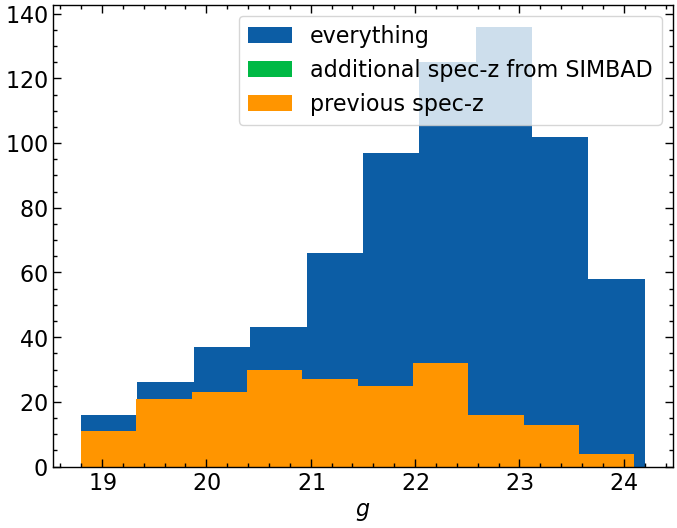

In [360]:
mask_specz_updated = np.isfinite(data_agn_des[r'$z_{\rm{sp}}$'].data)
plt.hist(data_agn_des['$g$'], label='everything')
plt.hist(data_agn_des['$g$'][mask_specz_updated], label='additional spec-z from SIMBAD')
mask_specz = np.isfinite(data_agn_des[r'$z_{\rm{sp}}$'].data)
plt.hist(data_agn_des['$g$'][mask_specz], label='previous spec-z')
plt.xlabel('$g$')
plt.legend(frameon=True, loc=1)

In [235]:
mask_specz = (data_agn_des[r'$z_{\rm{sp}}$ source']=='None') & (data_agn_des['$g$'] < 22) & (data_agn_des['Field'] == 'SN-X3')
data_agn_des[mask_specz]

Name,RA,dec,$g$,SNR,$\sigma_{\rm{LB}}$,$\log\ \frac{M_{\ast}}{M_{\odot}}$,$\Delta\chi_\nu^2$,"$\log\ \frac{\tau_{\rm{\textsc{DRW},rest}}}{\rm{days}}$",$z_{\rm{ph}}$,$z_{\rm{sp}}$,$z_{\rm{sp}}$ source,$W1{-}W2$,$\log \frac{F_{2-7 {\rm{\ keV}}}}{{\rm{erg\ s}}^{-1} {\rm{\ cm}}^{-2}}$,Field
str20,float64,float64,float64,float64,float64,str14,float64,str16,str22,float64,str4,float64,float64,str5
J022555.44-043918.34,36.481,-4.6551,21.0,21.2,16.3,$10.4 \pm 0.1$,37.3,$2.1 \pm 0.4$,$1.00^{+0.10}_{-0.40}$,nan,None,0.9,nan,SN-X3
J022501.86-044125.06,36.2578,-4.6903,21.4,19.3,16.9,$6.2 \pm 0.6$,0.3,$3.1 \pm 0.7$,$0.14^{+0.02}_{-0.01}$,nan,None,18.0,nan,SN-X3
J022416.66-045643.14,36.0694,-4.9453,21.1,20.6,15.1,$8.6 \pm 0.6$,-0.0,$1.8 \pm 0.3$,$1.05^{+0.05}_{-0.25}$,nan,None,1.0,nan,SN-X3


In [374]:
data_agn_des

Name,RA,dec,$g$,SNR,$\sigma_{\rm{LB}}$,$\log\ \frac{M_{\ast}}{M_{\odot}}$,$\Delta\chi_\nu^2$,"$\log\ \frac{\tau_{\rm{\textsc{DRW},rest}}}{\rm{days}}$",$z_{\rm{ph}}$,$z_{\rm{sp}}$,$z_{\rm{sp}}$ source,$W1{-}W2$,$\log \frac{F_{2-7 {\rm{\ keV}}}}{{\rm{erg\ s}}^{-1} {\rm{\ cm}}^{-2}}$,Field
str20,float64,float64,float64,float64,float64,str14,float64,str16,str22,float64,str4,float64,float64,str5
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,$1.02^{+0.03}_{-0.04}$,nan,None,0.4,nan,SN-C3
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,$0.24^{+0.04}_{-0.02}$,nan,None,18.6,nan,SN-C3
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,$1.09^{+0.02}_{-0.02}$,nan,None,0.9,nan,SN-C3
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,$1.30^{+0.10}_{-0.15}$,nan,None,1.1,nan,SN-C3
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,$0.60^{+0.25}_{-0.05}$,nan,None,nan,nan,SN-C3
J032850.22-271208.00,52.2093,-27.2022,19.2,26.1,20.3,$10.2 \pm 0.6$,0.0,$2.7 \pm 0.6$,$0.90^{+0.40}_{-0.30}$,0.803,SIMB,1.1,nan,SN-C3
J032913.11-271213.79,52.3046,-27.2038,22.9,21.6,17.2,$10.4 \pm 0.5$,0.3,$2.2 \pm 0.7$,$1.25^{+0.15}_{-0.10}$,nan,None,1.0,nan,SN-C3
J032847.11-271553.99,52.1963,-27.265,21.1,23.6,19.0,$7.3 \pm 0.1$,3.2,$3.6 \pm 0.4$,$0.08^{+0.03}_{-0.04}$,2.9784,2dF,18.1,nan,SN-C3
J033039.78-271740.97,52.6658,-27.2947,24.1,10.0,11.7,$9.6 \pm 0.5$,0.4,$1.9 \pm 0.4$,$1.45^{+0.02}_{-0.02}$,nan,None,nan,nan,SN-C3


### Figures

Mi vs. redshift

In [270]:
data_agn_cosmos[]

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,ID-COSMOS2015,z,z_phot,z0,z1,z2,z3,z4,z5,r_z,r_z0,r_z1,r_z4
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
1,150.74386,2.20245,22.71,1,1,1,1,1,6,594392,1.58,1.58,-1.0,-1.0,-1.0,1.58,1.561,-1.0,3,-1,-1,3
2,150.73557,2.19957,20.36,1,1,1,1,1,6,592797,3.5026,-1.0,3.5026,3.503096,-1.0,-1.0,3.499,-1.0,0,7,3,1
3,150.73353,2.15646,20.88,1,1,1,1,1,6,565402,0.979,1.03,0.979,0.9769,-1.0,1.03,0.977,-1.0,0,3,1,1
4,150.79702,2.13888,21.01,1,1,1,1,1,6,552225,0.5727,0.51,0.5727,0.5727,-1.0,0.51,0.573,-1.0,0,16,5,1
5,150.78259,2.19306,20.63,1,1,1,1,1,6,589540,0.5824,-1.0,0.5824,0.5847,-1.0,-1.0,0.585,-1.0,0,3,5,1
6,150.72019,2.24803,21.13,1,1,1,1,1,6,625595,0.6652,0.62,0.6652,0.6633,-1.0,0.62,0.664,-1.0,0,3,1,1
7,150.78838,2.34399,19.82,1,1,1,1,1,6,689768,1.9555,2.0,1.9555,1.964449,-1.0,2.0,1.964,-1.0,0,3,3,1
9,150.71391,1.97214,22.87,1,1,1,1,1,5,445280,1.53,1.53,-1.0,-1.0,-1.0,1.53,1.474,-1.0,3,-1,-1,3
10,150.63146,2.00264,23.26,1,1,1,1,1,6,463657,1.826,0.88,1.826,1.826,1.826,0.88,1.826,-1.0,0,18,6,2


In [252]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

In [365]:
z_ph[0]

1.02

In [375]:
# Read SDSS
hdul = fits.open('../dr16q_prop_May16_2023.fits')

In [378]:
#hdul[1].header

/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_11956/2601842634.py:9: RuntimeWarning: divide by zero encountered in log10
  Mi = data_agn_des['$g$'] - 5*np.log10(d.to(u.pc).value/10) - 0.26
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_11956/2601842634.py:39: RuntimeWarning: divide by zero encountered in log10
  Mi = data_agn_cosmos['i-mag'][mask_ph] - 5*np.log10(d.to(u.pc).value/10)
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_11956/2601842634.py:56: RuntimeWarning: divide by zero encountered in log10
  Mi = 22 - 5*np.log10(d.to(u.pc).value/10)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


267
4


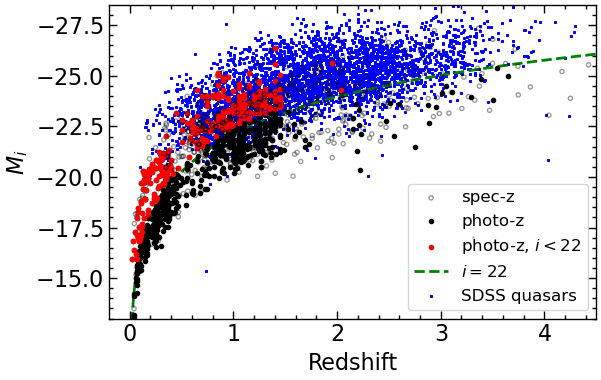

In [400]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))

### DES ###

# Spec-z
z_sp = data_agn_des[r'$z_{\rm{sp}}$'].data

d = cosmo.luminosity_distance(z_sp)
Mi = data_agn_des['$g$'] - 5*np.log10(d.to(u.pc).value/10) - 0.26

ax.scatter(z_sp, Mi, marker='.', edgecolors='k', color='none', alpha=0.4)

# Photo-z
z_ph = np.array([float(s[1:5]) for s in data_agn_des[r'$z_{\rm{ph}}$'].data])
d = cosmo.luminosity_distance(z_ph)
Mi = data_agn_des['$g$'] - 5*np.log10(d.to(u.pc).value/10) - 0.26

ax.scatter(z_ph, Mi, marker='.', color='k', zorder=1)

mask_br = data_agn_des['$g$'] < 22
ax.scatter(z_ph[mask_br], Mi[mask_br], marker='.', color='r', zorder=1)

print(len( Mi[mask_br]))

### HSC-SSP ###

mask_ph = data_agn_cosmos['z']!=data_agn_cosmos['z_phot']
z_sp = data_agn_cosmos['z'][mask_ph]

d = cosmo.luminosity_distance(z_sp)
Mi = data_agn_cosmos['i-mag'][mask_ph] - 5*np.log10(d.to(u.pc).value/10) + 0.26

ax.scatter(z_sp, Mi, label='spec-z', marker='.', edgecolors='k', color='none', alpha=0.4)

mask_ph = data_agn_cosmos['z']==data_agn_cosmos['z_phot']
z_sp = data_agn_cosmos['z'][mask_ph]

d = cosmo.luminosity_distance(z_sp)
Mi = data_agn_cosmos['i-mag'][mask_ph] - 5*np.log10(d.to(u.pc).value/10)

ax.scatter(z_sp, Mi, label='photo-z', marker='.', color='k', zorder=1)

mask_br = data_agn_cosmos['i-mag'][mask_ph] < 22
ax.scatter(z_sp[mask_br], Mi[mask_br], label=r'photo-z, $i < 22$', marker='.', color='r', zorder=1)

print(len( Mi[mask_br]))

### Mezcua ###



### det limit ###

z = np.linspace(0, 4.5, 1000)
d = cosmo.luminosity_distance(z)
Mi = 22 - 5*np.log10(d.to(u.pc).value/10)
ax.plot(z, Mi, label=r'$i=22$', color='g', linestyle='dashed', zorder=-1)

ax.set_xlim(-0.2, 4.5)
ax.set_ylim(-13, -28.5)

ax.scatter(hdul[1].data['Z_DR16Q'][::200], 90 - 2.5*hdul[1].data['LOGLBOL'][::200], marker='+', color='b', s=1, zorder=-10, label='SDSS quasars')


ax.set_xlabel(r'Redshift')
ax.set_ylabel(r'$M_i$')

ax.legend(fontsize=12, frameon=True, loc=4)

fig.tight_layout()
fig.savefig('Mi.eps', format='eps')